### Zaawansowane Metody Uczenia Maszynowego

[Problem ekspoludjącego gradientu](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)

#### Laboratorium 4

### Implementacja modelu regresji logistycznej z IRLS

In [1]:
from sklearn.datasets import make_classification
from numpy.linalg import inv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X, y = make_classification(random_state=42, n_samples=1000, n_features=8)

### Zadanie 1
----
Przygotuj funkcję `sigmoid`.

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### Zadanie 2
---
Przygotuj funkcję `cross_entropy_loss`.

In [3]:
def cross_entropy_loss(y_true, y_pred, clip_val = 1e-10):
    y_pred = np.clip(y_pred, clip_val, 1 -clip_val)
    loss = np.multiply(y_true, np.log(y_pred))
    total_loss = -np.sum(loss, axis = 0)
    return total_loss


### Zadanie 3
----
Przygotuj funkcję `transform_X`, która dla danej macierzy X doda pierwszą kolumnę zawierającą 1.

In [4]:
def transform_X(X):
    X = np.array(X)
    X = np.insert(X, 0, np.ones((X.shape[0])), axis = 1)
    return X
    

### Zadanie 4
---
Przygotuj funkcję `transform_y`, która przekształci wektor y na tablicę array.

In [5]:
def transform_y(y):
    y = np.array(y)
    y = y.reshape((y.shape[0], -1))
    return y


### Iteratively Reweighted Least Squares (IRLS/IWLS)
*maximum likelihood method*

Używając metody Raphson-Newton

$$\beta: \frac{\partial l}{\partial \beta} = 0$$

$$ 0 \approx \frac{\partial l}{\partial \beta}_{\beta = \beta^{new}} \approx \frac{\partial l}{\partial \beta}_{\beta = \beta^{old}} + H(\beta^{new} - \beta^{old}) $$

$$\beta^{new} = \beta^{old} - H^{-1}(\beta^{old})\frac{\partial l}{\partial \beta}_{\beta = \beta^{old}},$$

$H(\beta)$ - macierz drugich pochodnych (Hesjan).


$$\frac{\partial l}{\partial \beta} = X'(Y-p), \ \ \ \ \ \ \ \ \ \ \ \  p = (p(x1, \beta), \dots, p(x_n, \beta))'$$
$$H(\beta) = \frac{\partial^2 l}{\partial \beta \partial \beta'} = -X'WX,$$

gdzie $W = diag(p(x_1, \beta)(1-p(x_1, \beta)), \dots, p(x_n, \beta)(1-p(x_n, \beta)))$

$-H > 0$ dodatnio określona, $H^{-1}$ istnieje
$$\beta^{new} = \beta^{old} - H^{-1}(\beta^{old})\frac{\partial l}{\partial \beta}_{\beta = \beta^{old}},$$
podstawiając
$$\beta^{new} = \beta^{old} + (X'WX)^{-1}X'(Y-p).$$

### Zadanie 5
---
Przygotuj funkcję `optimize`, która wykorzystując algorytm IRLS będzie optymalizować rozwiązani w modelu regresji logistycznej.

In [6]:
def optimize(X, y, epoch = 10):

    X = transform_X(X)
    y = transform_y(y)

    # wektor początkowy dla bet
    betas = np.zeros((X.shape[1],1))

    # wektor do zapisywania funkcji straty
    losses = []
    for e in range(epoch):
        y_hat = sigmoid(np.matmul(X, betas))
        W = np.diag(np.ravel(y_hat*(1-y_hat)))
        grad = np.matmul(X.T, (y_hat-y))
        hessian = np.matmul(np.matmul(X.T, W), X) + 0.001*np.eye(X.shape[1])
        betas -= np.matmul(inv(hessian), grad)

        loss = cross_entropy_loss(y, sigmoid(np.matmul(X, betas)))
        losses.append(loss)


    coef = betas[1:]
    intercept = betas[0]
    
    return coef, intercept, losses

### Zadanie 6
---
Przygotuj klasę `LogisticRegression`, która będzie się składała z funkcji z wcześniejszych zadań. Dodatkowo dopisz fukcję `fit`, `predict_proba` i `predict`.

In [7]:
class LogisticRegression:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = self.transform_X(X)
        self.y = self.transform_y(y)
        self.N,self.P = self.X.shape
        self.optimize()

    def optimize(self, epoch = 10):

        # wektor początkowy dla bet
        betas = np.zeros((self.P,1))

        # wektor do zapisywania funkcji straty
        losses = []
        for e in range(epoch):
            y_hat = self.sigmoid(np.matmul(self.X, betas))
            W = np.diag(np.ravel(y_hat*(1-y_hat)))
            grad = np.matmul(self.X.T, (y_hat-self.y))
            hessian = np.matmul(np.matmul(self.X.T, W), self.X) + 0.001*np.eye(self.P)
            betas -= np.matmul(inv(hessian), grad)

            loss = self.cross_entropy_loss(self.y, self.sigmoid(np.matmul(self.X, betas)))
            losses.append(loss)

        self.coef = betas[1:]
        self.intercept = betas[0]
        self.losses = losses
        
    def predict(self, X, thres=0.5):
        X = np.array(X)
        y_pred= self.sigmoid(np.matmul(X,self.coef) + self.intercept)
        return np.where(y_pred > thres, 1, 0)
        
    def predict_proba(self, X):
        X = np.array(X)
        return self.sigmoid(np.matmul(X,self.coef) + self.intercept)
    
    def transform_X(self, X):
        X = np.array(X)
        X = np.insert(X, 0, np.ones((X.shape[0])), axis = 1)
        return X
    
    def transform_y(self, y):
        y = np.array(y)
        y = y.reshape((y.shape[0], -1))
        return y

    def cross_entropy_loss(self, y_true, y_pred, clip_val = 1e-10):
        y_pred = np.clip(y_pred, clip_val, 1 -clip_val)
        loss = np.multiply(y_true, np.log(y_pred))
        total_loss = -np.sum(loss, axis = 0)
        return total_loss

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

### Działanie klasy *LogisticRegression*

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [9]:
LR_model = LogisticRegression()
LR_model.fit(X_train,y_train)

In [10]:
LR_model.intercept

array([0.21996782])

In [11]:
LR_model.coef

array([[-0.03975911],
       [ 0.00997589],
       [-0.4274332 ],
       [-0.71704661],
       [-0.6362002 ],
       [-0.0276373 ],
       [ 1.57059313],
       [ 0.04991876]])

Text(0.5, 1.0, 'Funkcja straty')

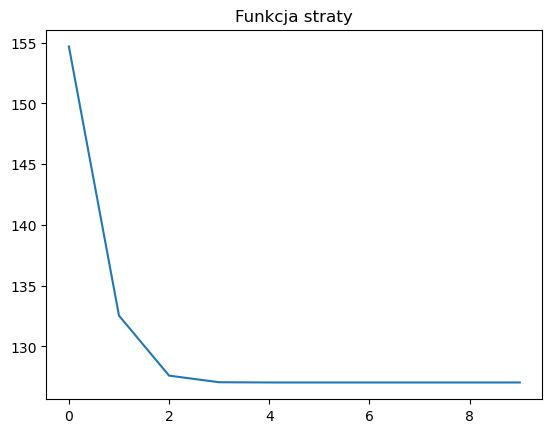

In [12]:
plt.plot(range(10), LR_model.losses)
plt.title('Funkcja straty')


### Zadanie 7*
-----
Przygotuj model regresji logistycznej jako sieć neuronowa używając pakietu `Keras`.